In [14]:
import GPy
import GPyOpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


This may sound simple because you only have a two-dimensional input, however it is a very difficult problem. It corresponds to trying to find the source of radiation in some square area. However, you can only detect the radiation once you are very close to it, meaning most of the readings will be zero. There are two sources, one is not too dangerous, so make sure you try to find both modes of the function.

In [15]:
def load_initial_data(inputs_file, outputs_file) -> pd.DataFrame:
    X = np.load(inputs_file)
    y = np.load(outputs_file)
    df = pd.DataFrame(X, columns=['x1', 'x2'])
    df['y'] = y
    return df

df1 = load_initial_data(
    '../initial_data/function_1/initial_inputs.npy',
    '../initial_data/function_1/initial_outputs.npy',
)
df2 = load_initial_data(
    '../initial_data2/function_1/initial_inputs.npy',
    '../initial_data2/function_1/initial_outputs.npy',
)

df = pd.concat([df1, df2], ignore_index=True)

df.head()


,x1,x2,y
0,0.319404,0.762959,1.322677e-79
1,0.574329,0.879898,1.033078e-46
2,0.731024,0.733000,7.710875e-16
3,0.840353,0.264732,3.341771e-124
4,0.650114,0.681526,-3.606063e-03


In [16]:
import re

df_feedback = pd.read_csv('../initial_data/561_data.csv')

df_feedback = df_feedback[['f1', 'f1_output']]
df_feedback['f1'] = df_feedback['f1'].apply(lambda x: re.findall(r'\d+\.\d*', x))

for i in range(len(df_feedback['f1'].iloc[0])):
    df_feedback[f'x{i+1}'] = df_feedback['f1'].apply(lambda x: float(x[i]))

df_feedback.drop('f1', axis=1, inplace=True)
df_feedback = df_feedback.rename(columns={'f1_output': 'y'})
df_feedback = df_feedback[['x1', 'x2', 'y']]

df = pd.concat([df, df_feedback], ignore_index=True)
df.describe()

,x1,x2,y
count,37.000000,37.000000,3.700000e+01
mean,0.569262,0.549433,1.097052e-03
std,0.238176,0.223424,1.107460e-02
min,0.069389,0.078723,-6.146911e-03
25%,0.469376,0.403488,-4.052801e-15
50%,0.596486,0.614080,-7.409586e-118
75%,0.671431,0.681526,1.033078e-46
max,0.962275,0.908318,6.591476e-02


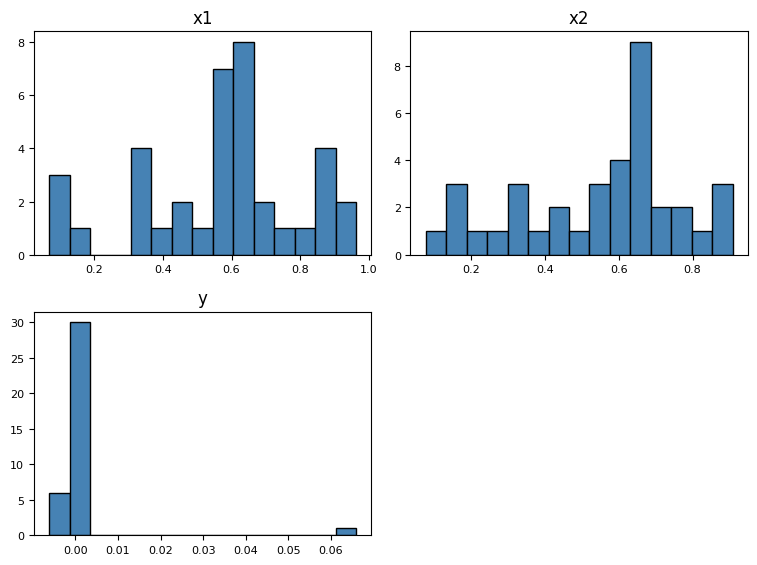

In [17]:
df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

In [18]:
def analyse_param(df, x, y):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    # Plot histogram
    axes[0].set_xlabel(x)
    axes[0].set_ylabel("Frequency")
    axes[0].hist(df[x], bins=15, color='steelblue', edgecolor='black', linewidth=1.0)

    # Plot density
    axes[1].set_xlabel(x)
    axes[1].set_ylabel("Frequency")
    sns.kdeplot(df[x], ax=axes[1], color='steelblue', shade=True, legend=False)

    # Plot scatter
    axes[2].set_xlabel(x)
    axes[2].set_ylabel(y)
    axes[2].scatter(df[x], df[y], s=30, edgecolor='black', alpha=0.7)

    plt.tight_layout()
    plt.show()


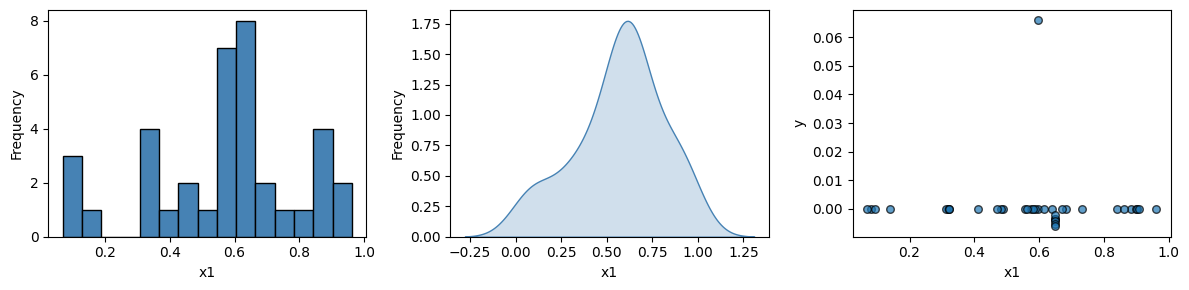

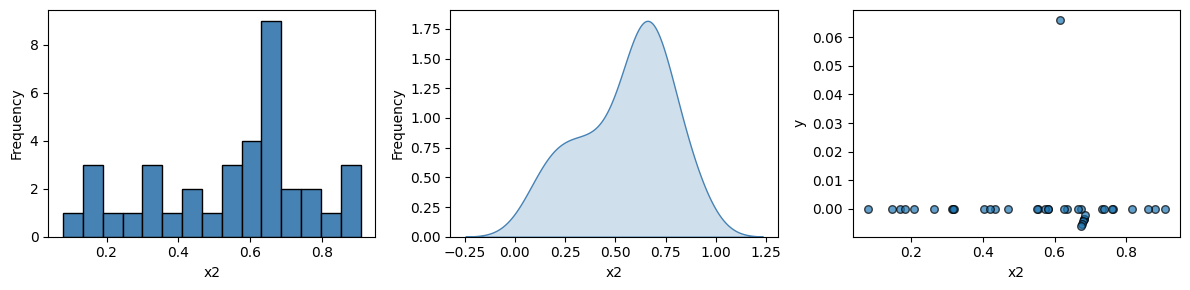

In [19]:
analyse_param(df, 'x1', 'y')
analyse_param(df, 'x2', 'y')

In [20]:
def analyse_corr_to_y(df):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Plot correlation to y
    corr = df.corr()
    sns.heatmap(corr[['y']], annot=True, cmap='coolwarm', ax=axes[0])

    # Plot scatter
    axes[1].set_xlabel("x1")
    axes[1].set_ylabel("x2")
    axes[1].scatter(df['x1'], df['x2'], s=30, edgecolor='black', c=df['y'], cmap='coolwarm', alpha=0.7)

    plt.tight_layout()
    plt.show()

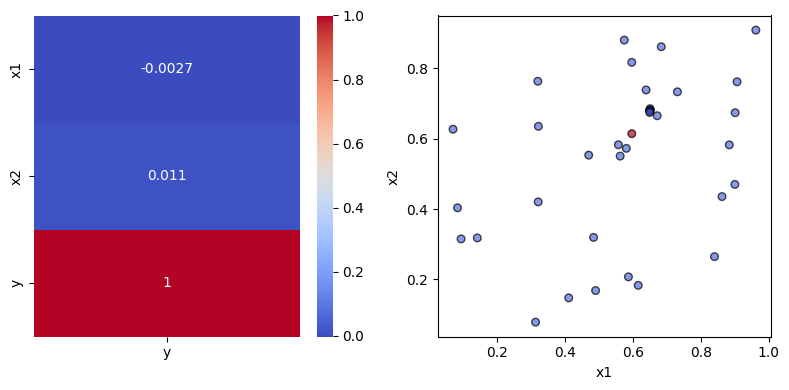

In [21]:
analyse_corr_to_y(df)

In [22]:
def pairwise_relationship(df):
    sns.pairplot(df, kind='scatter', diag_kind='kde', plot_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'black'})
    plt.tight_layout()
    plt.show()

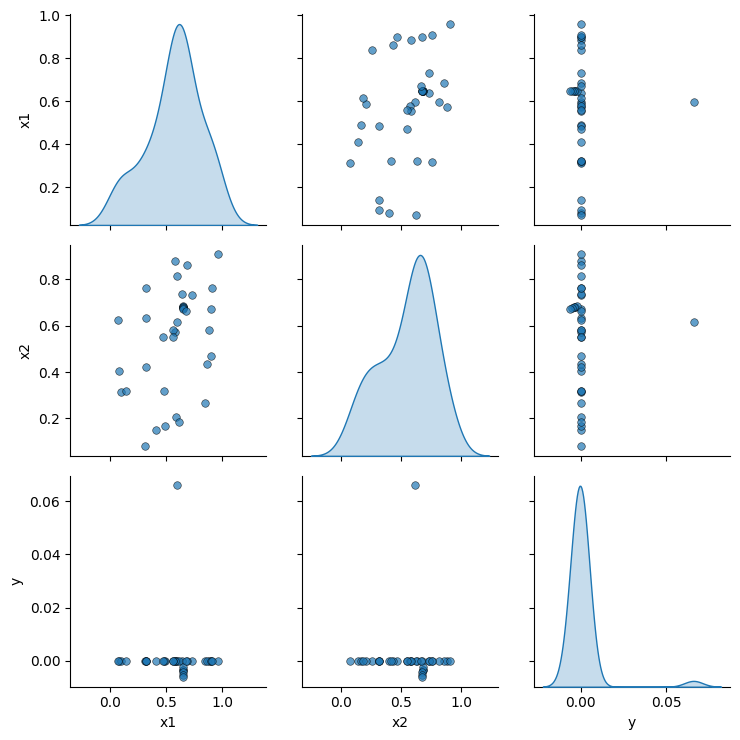

In [23]:
pairwise_relationship(df)

In [24]:
def objective_fn(x):
    return -(np.array([x[:, 0] + x[:, 1]]).T)

objective = GPyOpt.core.task.SingleObjective(objective_fn)

space = GPyOpt.Design_space(
    space=[{'name': 'x1', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 0.999999)}]
)

gp_kernel = GPy.kern.Matern32(
    input_dim=2,
    variance=1.0,
    lengthscale=1.0
)

model = GPyOpt.models.GPModel(
    exact_feval=False,
    optimize_restarts=5,
    verbose=False,
    kernel=gp_kernel
)

acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

initial_design = GPyOpt.experiment_design.initial_design('random', space, 5)

acquisition = GPyOpt.acquisitions.AcquisitionEI(model, space, acquisition_optimizer, jitter=0.01)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

bo = GPyOpt.methods.ModularBayesianOptimization(
    model, space, objective, acquisition, evaluator,
    X_init=df[['x1', 'x2']].values,
    Y_init=df['y'].values.reshape(-1, 1),
    de_duplication=True
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


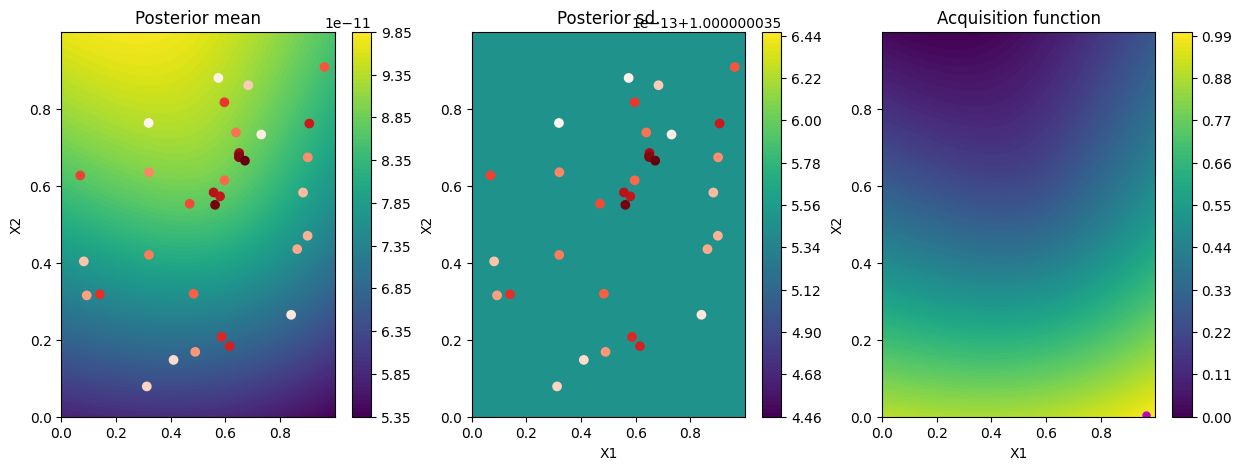

In [25]:
bo.plot_acquisition()

In [26]:
x_next = bo.suggest_next_locations()
print(f"next_query: {'-'.join(['%.6f' % x for x in x_next[0]])}")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
